## 03. 평균 이동 
#### 평균 이동(Mean Shift)의 개요 
- K평균과 유사 -> 중심을 군집의 중심으로 지속적으로 이동 -> 군집화 수행  
  but 차이점: 중심 이동 방식-> 중심을 데이터가 모여있는 밀도가 가장 높은 곳으로 이동 (cf.K-평균: 중심이 소속된 데이터의 평균 거리 중심으로 이동)
- 데이터 분포도를 이용해 군집 중심점(데이터 포인트가 모여있는 곳)을 찾음(=확률 밀도 함수(pdf)가 피크인 점)  
  -> KDE(Kernel Density Estimation) 이용하여 pdf 찾음
- 평균이동 군집화
  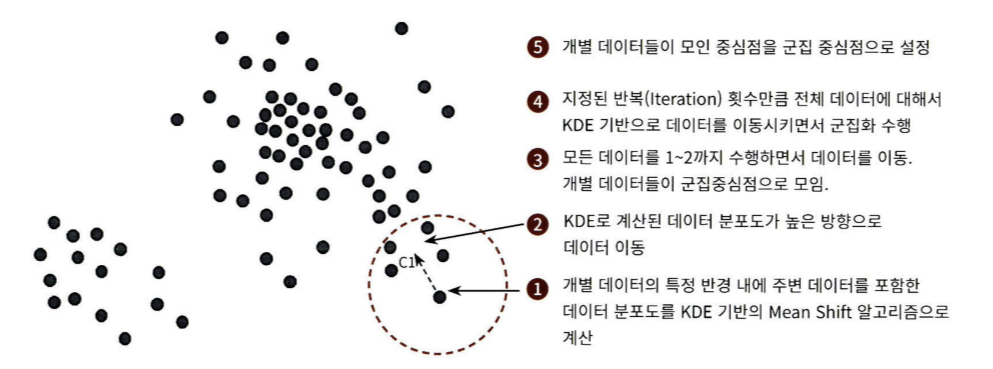  
- KDE
  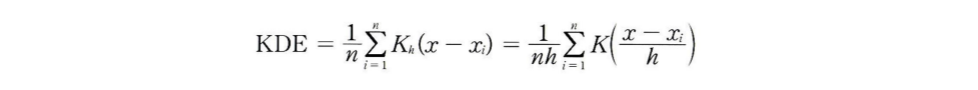
  K: 커널함수, x: 확률 변숫값, xi: 관측값 h:대역폭(bandwidth)
  - 커널 함수를 통해 어떤 변수의 확률 밀도 함수를 추정하는 대표적 방법
  - 관측된 데이터 각각에 커널함수 적용 값을 모두 더한 후 데이터 건수로 나눠 확률 밀도 함수 추정
    - 확률밀도함수: 확률 변수의 분포 ex) 정규분포, 감마분포, t-분포 -> 특정 변수가 어떤 값을 갖게 될지에 대한 확률을 알 수 O
      => 변수의 특성(정규 분포의 경우, 평균&분산), 확률 분포 등 변수의 많은 요소를 알 수 O
    - 대표적 커널함수: 가우시안 분포 함수
      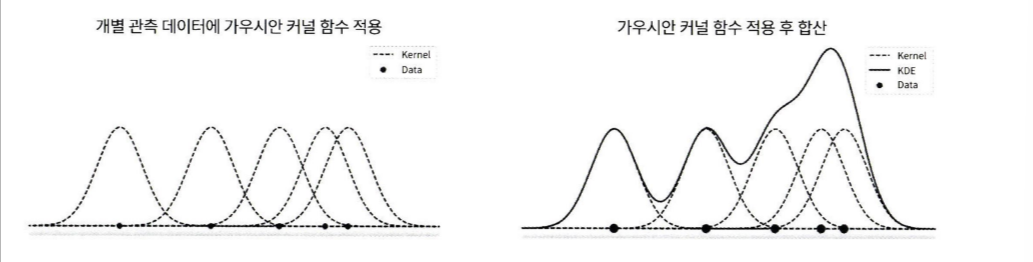  
    - 대역폭 h: KDE 형태를 부드러운(or 뾰족한) 형태로 평활화(Smoothing)하는데 적용 -> 확률 밀도 추정 성능을 크게 좌우 O 
       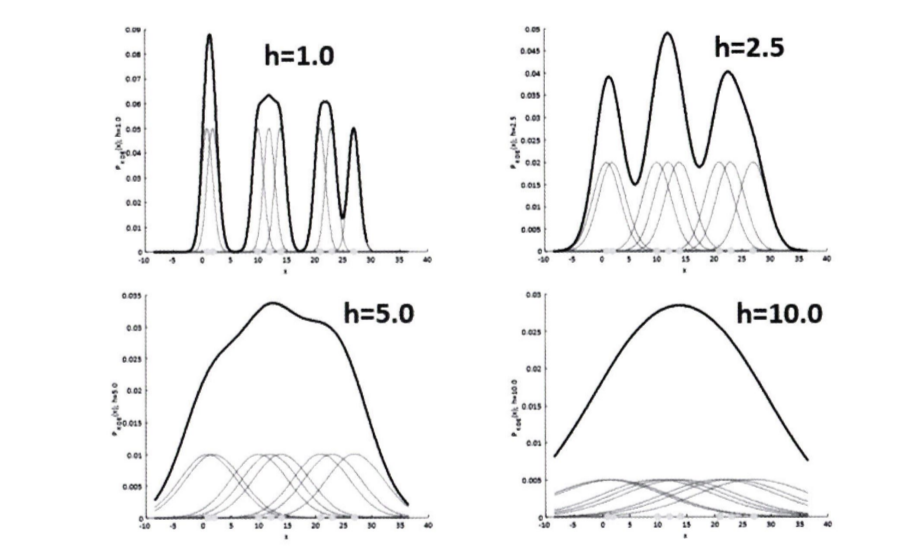  
      -> wkrdmftnfhr 과적합하기 쉽고, 클수록 과소적합 하기 쉬움 0 -> 적절한 대역폭 계산이 매우 중요
  - 대역폭이 클수록 평활화된 KDE -> 적은 수의 군집 붖ㅇ심점
  - 군집의 개수를 지정하지 않고, 대역폭의 크기에 따라 군집화 수행
- 평균이동군집화 : MeanShift 클래스
  - bandwidth : KDE의 대역폭 h
  - 최적 대역폭 계산: estimate_bandwidth()함수
- 평균 이동의 장점
  1. 데이터 세트의 형태를 특정 형태로 or 특정 분포도 기반의 모델로 가정 X -> 좀 더 유연한 군집화 가능
  2. 이상치의 영향력 크지 X, 미리 군집의 개수 정할 필요 X
- 평균이동의 단점
  1. 알고리즘 수행 시간이 오래걸림
  2. bandwidth의 크기에 따른 군집화 영향도가 매우 큼  
=> 컴퓨터 비전 영역에서 더 많이 사용, 이미지나 영상 데이터에서 특정 개체 구분 or 움직임 추적하는데 뛰어난 역할을 하는 알고리즘

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


In [3]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


- 최적화된 bandwidth 값 반환 : estimate_bandwidth()

In [4]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 1.816


In [5]:
import pandas as pd 

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y 

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


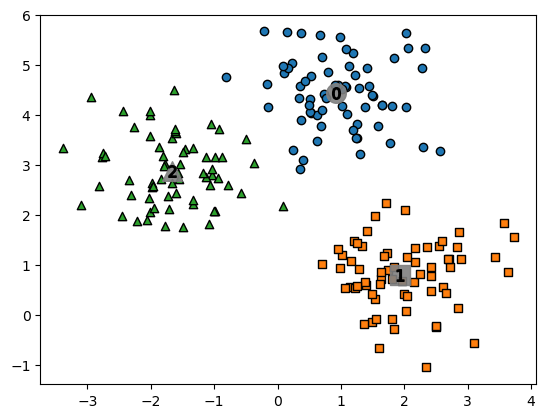

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers = ['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label'] == label]
    center_x_y = centers[label]
    
    # 군집별로 다른 마커로 산점도 적용 
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)

plt.show()

In [7]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


## 04. GMM(Gaussian Mixture Model)
#### GMM(Gaussian Mixture Model) 소개
- 가정: 군집화를 적용하고자 하는 데이터가 여러 개의 가우시간 분포를 가진 데이터 집합들이 섞여서 생성된 것 -> 군집화 수행
  - 가우시간 분포: 좌우 대칭형의 종 형태를 가진 가장 잘 알려진 연속 확률 함수
  - 표준 정규 분포
    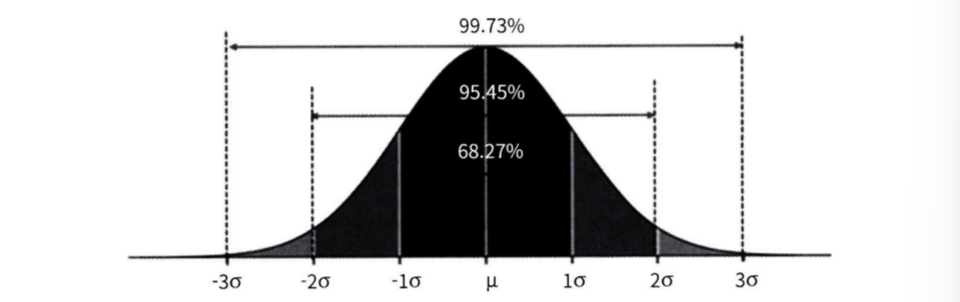   
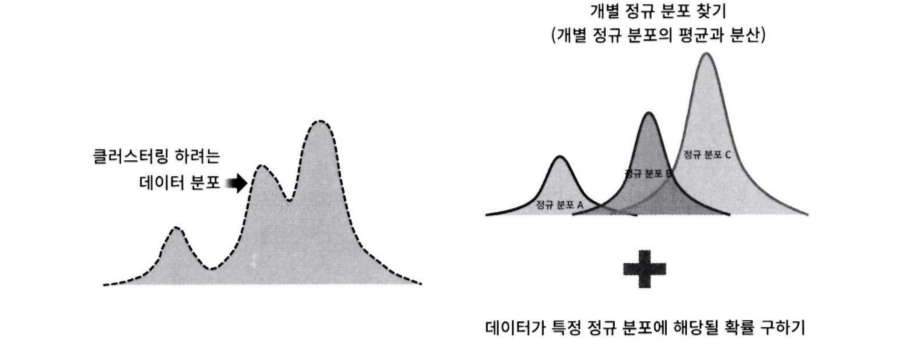  
-> n개의 데이터 세트를 구성하는 여러개의 정규 분포 곡선 추출  
-> 서로 다른 정규 분포에 기반해 개별 데이터가 이 중 어떤 정규 분포에 속하는 지 군집화 수행  
=> GMM의 모수추정  
    1. 개별 정규 분포의 평균과 분산
    2. 각 데이터가 어떤 정규 분포에 해당되는 지의 확률  
    -> EM(Expectation and Maximization) 방법 적용 : GaussianMixture 클래스

#### GMM을 이용한 붓꽃 데이터 세트 군집화

In [8]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris=load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns = feature_names)
irisDF['target'] = iris.target

- Gaussian Mixture
  - n_components: gaussian mixture 모델의 총 개수 

In [10]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 군집화 결과를 irisDF의 'gmm_cluster' 칼럼 명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target 

# target 값에 따라 gmm_cluster 값이 어떻게 매핑됐는지 확인.
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: count, dtype: int64


C:\Users\leehj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


- 붓꽃 데이터 세트의 K-평균 군집화 

In [11]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

C:\Users\leehj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\leehj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: count, dtype: int64


-> 개별 군집 내의 데이터가 원형으로 흩어져 있는 경우에 매우 효과적으로 군집화 수행 가능

#### GMM과 K-평균의 비교
- GMM
  - 군집의 중심좌표를 구할 수 X -> 시각화X
  - KkMeans보다 유연하게 다양한 데이터 세트에 잘 적용 but 군집화 수행 시간이 오래 걸림 
- K-평균
  - 원형의 범위에서 군집화 수행 -> 타원형의 데이터의 경우 군집화 잘 수행하지 못함.
  - 데이터 세트가 원형 범위를 가질 수록 군집화 효율이 높아짐 

In [13]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

- 데이터가 원형 범위로 퍼져있지 않은 경우의 KMeans 군집화

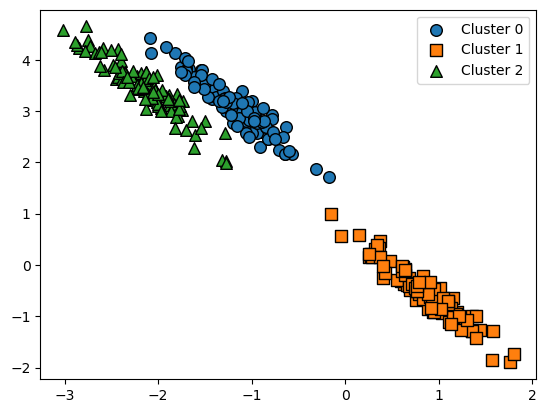

In [15]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개의 데이터 세트, 3개의 군집 세트, cluster_std=0.5를 만듦.
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 세트를 생성하기 위해 변환함.
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 세트와 make_blobs()의 y 결괏값을 DataFrame으로 저장
clusterDF=pd.DataFrame(data=X_aniso, columns = ['ftr1','ftr2'])
clusterDF['target']=y
# 생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화함
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

C:\Users\leehj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\leehj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


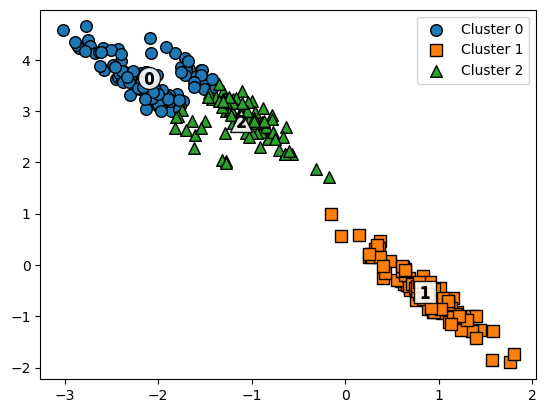

In [18]:
# 3개의 군집 기반 Kmeans를 X_aniso 데이터 세트에 적용
kmeans=KMeans(3,random_state=0)
kmeans_label=kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

-> 주로 원형 위치로 개별 군집화 되며 우너하는 방향으로 구성되지 않음

- 데이터가 길쭉한 방향으로 데이터가 밀집해있을 경우의 GMM 군집화

C:\Users\leehj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


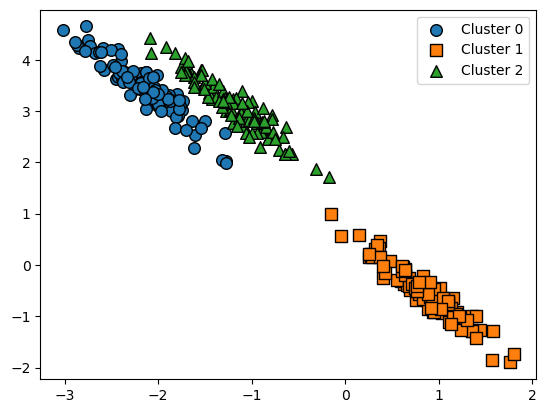

In [20]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용 
gmm=GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter=False로 설정
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

- KMeans와 GMM 군집의 Label 값 비교 -> 군집화 효율 차이 발생여부 확인

In [21]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64
